# Analyze Model Results

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from MemoryAutoScaling import analysis, plotting, specs
from MemoryAutoScaling.Analysis import HarvestStats

pd.set_option('display.max_columns', None)

### Function Definitions

In [2]:
def render_params_bar_plot(params, counts, model_name):
    """Renders a bar plot of `params` for `model_name` based on `counts`.
    
    Parameters
    ----------
    params: np.array
        A numpy array of the most common optimal parameters.
    counts: np.array
        A numpy array of integers representing counts for the parameters.
    model_name: str
        A string representing the name of the model.
    
    Returns
    -------
    None
    
    """
    n = len(params)
    plt.figure(figsize=(20, 10))
    plt.bar(range(n), counts)
    plt.xticks(range(n), params, rotation=-15)
    plt.title("{} Model Most Common Optimal Parameter".format(model_name.upper()))
    plt.show()

In [3]:
def plot_most_prominent_params(model_results_df, top_params_count, model_name):
    """A plot of the `top_params_count` most prominent parameters in `model_results_df`.
    
    Parameters
    ----------
    model_results_df: pd.DataFrame
        A pandas DataFrame containing model results.
    top_params_count: int
        An integer representing the number of parameters to be included in the plot.
        The `top_params_count` most prominent parameters of `model_results_df` are plotted.
    model_name: str
        A string representing the name of the model.
    
    Returns
    -------
    None
    
    """
    params_data = model_results_df.groupby('params_{}'.format(model_name))['id'].count()
    params_data = params_data.sort_values(ascending=False)
    if len(params_data) > 5:
        params_data = params_data[:5]
    render_params_bar_plot(params_data.index, params_data.values, model_name)

In [4]:
def build_model_result_cdfs(model_results_df, model_name):
    """Builds CDFs of model result statistics for `model_name` from `model_results_df`.
    
    The CDFs are built for each model result statistic across all the traces modeled.
    
    Parameters
    ----------
    model_results_df: pd.DataFrame
        A pandas DataFrame containing the model results for all traces.
    model_name: str
        A string representing the name of the model fit to the traces.
    
    Returns
    -------
    None
    
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    colors = ["blue", "red"]
    col_lst = ["test_mase", "under_mase"]
    for idx in range(len(colors)):
        col_name = "{0}_{1}".format(col_lst[idx], model_name)
        data_vals = model_results_df[col_name].values
        title_comps = col_name.title().split("_")
        title = " ".join(title_comps[:-1]) + " {}".format(title_comps[-1].upper())
        plotting.plot_cumulative_distribution_function(
            data_vals, axes[idx], title, colors[idx], "CDF")

In [5]:
def plot_harvest_df_cdfs(harvest_df, harvest_stat_cols, buffer_pct):
    """Plots CDFs of `harvest_stat_cols` from `harvest_df` at `buffer_pct`.
    
    Plots a cumulative distribution function for each column of `harvest_df`
    based on the columns in `harvest_stat_cols` and `buffer_pct`.
    
    Parameters
    ----------
    harvest_df: pd.DataFrame
        A pandas DataFrame containing the harvest data to be plotted acrosss
        all traces.
    harvest_stat_cols: list
        A list of strings representing the names of the columns to be plotted
        from `harvest_df`.
    buffer_pct: float
        A float representing the buffer percentage used to calculate the harvest
        statistics in `harvest_df`.
    
    Returns
    -------
    None
    
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    colors = ["blue", "red"]
    for idx in range(2):
        col_name = harvest_stat_cols[idx]
        data_vals = harvest_df[col_name].values
        title = "{0} With {1}% Buffer".format(" ".join(col_name.title().split("_")), int(buffer_pct * 100))
        plotting.plot_cumulative_distribution_function(data_vals, axes[idx], title, colors[idx], "CDF")
    plt.show()

In [6]:
def plot_harvest_df_scatter(harvest_df, harvest_stat_cols, buffer_pct):
    """A scatterplot for `harvest_stat_cols` based on the data in `harvest_df`.
    
    Parameters
    ----------
    harvest_df: pd.DataFrame
        A pandas DataFrame containing the harvest data to be plotted acrosss
        all traces.
    harvest_stat_cols: list
        A list of strings representing the names of the columns to be plotted
        from `harvest_df`.
    buffer_pct: float
        A float representing the buffer percentage used to calculate the harvest
        statistics in `harvest_df`.
    
    Returns
    -------
    None
    
    """
    plt.figure(figsize=(20, 10))
    plt.scatter(harvest_df[harvest_stat_cols[0]].values, harvest_df[harvest_stat_cols[1]].values)
    plt.xlabel(" ".join(harvest_stat_cols[0].split("_")).title())
    plt.ylabel(" ".join(harvest_stat_cols[1].split("_")).title())
    plt.ylim(0, 1)
    plt.title("Harvest Statistics with {}% Buffer".format(int(buffer_pct*100)))
    plt.show()

In [7]:
def print_summary_for_buffer(model_harvest_df, harvest_stats_cols, pct_buffer, model_name):
    """A summary of `model_harvest_df` for `harvest_stats_cols` at `pct_buffer`.
    
    The summary consists of cumulative distribution functions for the columns of
    `model_harvest_df` indicated by `harvest_stats_cols` at `pct_buffer`. In
    addition, the summary contains a summary of these columns in table format.
    
    Parameters
    ----------
    model_harvest_df: pd.DataFrame
        A pandas DataFrame containing the harvest statistics results for
        `harvest_stats_cols` at `pct_buffer`.
    harvest_stats_cols: list
        A list of strings representing the names of the columns for which the
        summary is generated.
    pct_buffer: float
        A float representing the buffer percentage used to generate the harvest
        statistics.
    model_name: str
        A string representing the name of the model for which the results were 
        generated.
    
    Returns
    -------
    None
    
    """
    buffer_harvest_cols = ["{0}_{1}_{2}".format(
                                harvest_col, pct_buffer, model_name) 
                           for harvest_col in harvest_stats_cols]
    buffer_harvest_df = model_harvest_df[buffer_harvest_cols].abs()
    buffer_harvest_df.columns = harvest_stats_cols
    plot_harvest_df_cdfs(buffer_harvest_df, harvest_stats_cols, pct_buffer)
    plot_harvest_df_scatter(buffer_harvest_df, harvest_stats_cols, pct_buffer)
    print(buffer_harvest_df.describe())

In [8]:
def summarize_harvest_results_for_model_results_df(model_results_df, model_name):
    """Summarizes the model results for `model_name` in `model_results_df`.
    
    A summary is created for each buffer percentage for which the harvest statistics
    in `model_results_df` were generated.
    
    Parameters
    ----------
    model_results_df: pd.DataFrame
        A pandas DataFrame containing the best model results for each trace
        when a model of class `model_name` was tuned on the trace.
    model_name: str
        A string representing the name of the model for which the results were
        generated.
    
    Returns
    -------
    None
    
    """
    harvest_stat_columns = HarvestStats.get_harvest_stat_columns()
    for buf_pct in specs.BUFFER_PCTS:
        print_summary_for_buffer(
            model_results_df, harvest_stat_columns, buf_pct, model_name)

In [9]:
def get_model_results(data_dir, top_params_count, model_name):
    """Retrieves the model results for `model_name` from `data_dir`.
    
    Parameters
    ----------
    data_dir: str
        A string representing the directory containing the model results.
    top_params_count: int
        An integer representing the number of parameters to be included in the plot.
        The `top_params_count` most prominent parameters of `model_results_df` are plotted.
    model_name: str
        A string representing the name of the model for which results are retrieved.
    
    Returns
    -------
    pd.DataFrame
        A pandas DataFrame containing the model results.
    
    """
    model_df = pd.read_csv(os.path.join(data_dir, "{}_results.csv".format(model_name)))
    model_df = model_df[~np.isnan(model_df['test_mase_{}'.format(model_name)])]
    print(model_df.describe())
    plot_most_prominent_params(model_df, top_params_count, model_name)
    build_model_result_cdfs(model_df, model_name)
    summarize_harvest_results_for_model_results_df(model_df, model_name)
    return model_df

In [10]:
def plot_cdfs_across_models(results_dfs, cdf_col):
    """Plots the CDFs of `cdf_col` across the models of `results_dfs`.
    
    Parameters
    ----------
    results_dfs: dict
        A dictionary of model results. The keys are strings representing the
        name of the model. The corresponding value is a pandas DataFrame
        recording results for the model across all traces.
    cdf_col: str
        A string representing the name of the variable for which the CDFs are
        generated.
    
    Returns
    -------
    None
    
    """
    styles = ['b-', 'g--', 'r-.', 'c:', 'm.', 'bo', 'k^']
    plt.figure(figsize=(20, 10))
    idx = 0
    for model_name in results_dfs.keys():
        dist_vals = results_dfs[model_name]["{0}_{1}".format(cdf_col, model_name)].values
        x, y = plotting.get_cdf_values(dist_vals)
        plt.plot(x, y, styles[idx], label=model_name.upper())
        idx += 1
    plt.title("CDFs of {} Across Models".format(" ".join(cdf_col.title().split("_"))))
    plt.legend()
    plt.show()

In [11]:
def plot_harvest_cdfs_across_models(results_dfs, cdf_col):
    """Plots the CDFs of `cdf_col` across the models of `results_dfs`.
    
    Parameters
    ----------
    results_dfs: dict
        A dictionary of model results. The keys are strings representing the
        name of the model. The corresponding value is a pandas DataFrame
        recording results for the model across all traces.
    cdf_col: str
        A string representing the name of the variable for which the CDFs are
        generated.
    
    Returns
    -------
    None
    
    """
    styles = ['b-', 'g--', 'r-.', 'c:', 'm.', 'bo', 'k^']
    plt.figure(figsize=(20, 10))
    idx = 0
    for model_name in results_dfs.keys():
        dist_vals = results_dfs[model_name]["{0}_{1}".format(cdf_col, model_name)].values
        x, y = plotting.get_cdf_values(dist_vals)
        plt.plot(x, y, styles[idx], label=model_name.upper())
        idx += 1
    cdf_col_comps = cdf_col.split("_")
    buffer = int(float(cdf_col_comps[-1]) * 100)
    col_name = " ".join(cdf_col_comps[:-1]).title()
    plt.title("CDFs of {0} Across Models with {1}% Buffer".format(col_name, buffer))
    plt.legend()
    plt.show()

In [12]:
def plot_all_cdfs_across_models(results_dfs):
    """Plots all of the model result CDFs across the models of `results_dfs`.
    
    Parameters
    ----------
    results_dfs: dict
        A dictionary of model results. The keys are strings representing the
        name of the model. The corresponding value is a pandas DataFrame
        recording results for the model across all traces.
    
    Returns
    -------
    None
    
    """
    for cdf_col in ["test_mase", "under_mase"]:
        plot_cdfs_across_models(results_dfs, cdf_col)
    for cdf_col in HarvestStats.get_harvest_columns_for_buffers():
        plot_harvest_cdfs_across_models(results_dfs, cdf_col)

In [13]:
def render_best_model_bar_plot(model_names, counts):
    """Renders a bar plot of the `counts` data for `model_names`.
    
    Parameters
    ----------
    model_names: np.array
        A numpy array of strings representing the names of the best models.
    counts: np.array
        A numpy array of integers representing the counts for each model of
        `model_names` of traces for which that model performs best.
    
    Returns
    -------
    None
    
    """
    n = len(model_names)
    plt.figure(figsize=(20, 10))
    plt.bar(range(n), counts)
    plt.xticks(range(n), model_names)
    plt.title("Counts of Best Model Types")
    plt.show()

In [14]:
def plot_counts_of_best_model_types(best_models_df):
    """Plots the counts of best model types from `best_models_df`.
    
    A bar plot is rendered which counts the model of each type in
    `best_models_df`.
    
    Parameters
    ----------
    best_models_df: pd.DataFrame
        A pandas DataFrame containing the results for the best model for each
        trace. There is a row for each trace specifying the trace id, model name,
        model parameters, and model results.
    
    Returns
    -------
    None
    
    """
    counts_data = best_models_df.groupby('model')['id'].count()
    counts_data = counts_data.sort_values(ascending=False)
    render_best_model_bar_plot(counts_data.index, counts_data.values)

In [15]:
def display_best_model_results_for_all_traces(data_dir):
    """Displays a summary of the best model results found in `data_dir`.
    
    A pandas DataFrame of the best model results is loaded from `data_dir`. For
    this dataframe, summary statistics are printed. Then a bar plot is created
    which counts the number of traces for which each model outperforms all other
    models. Lastly, a plot of 4 CDFs summarizing the 4 model evaluation parameters
    is plotted across all traces.
    
    Parameters
    ----------
    data_dir: str
        A string representing the directory from which the best model results
        are loaded.
    
    Returns
    -------
    pd.DataFrame
        A pandas DataFrame of the best model results for each trace.
    
    """
    best_model_df = pd.read_csv(os.path.join(data_dir, "best_model_results.csv"))
    print(best_model_df.describe())
    plot_counts_of_best_model_types(best_model_df)
    build_model_result_cdfs(best_model_df, "best")
    summarize_harvest_results_for_model_results_df(best_model_df, "best")
    return best_model_df

In [16]:
def compare_model_harvest_results(model_dfs):
    """Compares model harvest percentages across models in `model_dfs`.
    
    For each buffer percentage a plot is rendered showing the proportion of
    the total resource harvested across all traces for each model.
    
    Parameters
    ----------
    model_dfs: dict
        A dictionary of model results DataFrames. The keys are strings representing
        the names of the model and the associated value is the corresponding model
        results DataFrame for that model.
    
    Returns
    -------
    None
    
    """
    for buffer_pct in specs.BUFFER_PCTS:
        analysis.plot_prop_harvested_by_model(model_dfs, buffer_pct)

### Maximum Memory Usage - 3 Period Aggregation

In [ ]:
max_mem_3_dir = "/Users/mattb/Desktop/Courses/MemoryAutoScaling/output_data/max_mem_3"
model_results_dfs = {}

In [ ]:
model_results_dfs['ma'] = get_model_results(max_mem_3_dir, 5, "ma")

In [ ]:
model_results_dfs['es'] = get_model_results(max_mem_3_dir, 5, "es")

In [ ]:
model_results_dfs['ar'] = get_model_results(max_mem_3_dir, 5, "ar")

In [ ]:
model_results_dfs['reg'] = get_model_results(max_mem_3_dir, 5, "reg")

In [ ]:
model_results_dfs['svm'] = get_model_results(max_mem_3_dir, 5, "svm")

In [ ]:
model_results_dfs['xgb'] = get_model_results(max_mem_3_dir, 5, "xgb")

In [ ]:
model_results_dfs['arima'] = get_model_results(max_mem_3_dir, 5, "arima")

In [ ]:
plot_all_cdfs_across_models(model_results_dfs)

In [ ]:
compare_model_harvest_results(model_results_dfs)

In [ ]:
analysis.output_best_model_results_from_model_results_dfs(model_results_dfs, max_mem_3_dir)

In [ ]:
model_names = list(model_results_dfs.keys()) + ['best']

In [ ]:
model_results_dfs['best'] = display_best_model_results_for_all_traces(max_mem_3_dir)

In [ ]:
print("Test MASE")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "test_mase")

In [ ]:
print("Under Predictions MASE")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "under_mase")

In [ ]:
print("Proportion of Memory Harvest with 0% Buffer")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "prop_harvested_0.0")

In [ ]:
print("Proportion of Violations with 0% Buffer")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "prop_violations_0.0")

### Maximum CPU Usage - 3 Period Aggregation

In [ ]:
max_cpu_3_dir = "/Users/mattb/Desktop/Courses/MemoryAutoScaling/output_data/max_cpu_3"
model_results_dfs = {}

In [ ]:
model_results_dfs['ma'] = get_model_results(max_cpu_3_dir, 5, "ma")

In [ ]:
model_results_dfs['es'] = get_model_results(max_cpu_3_dir, 5, "es")

In [ ]:
model_results_dfs['ar'] = get_model_results(max_cpu_3_dir, 5, "ar")

In [ ]:
model_results_dfs['reg'] = get_model_results(max_cpu_3_dir, 5, "reg")

In [ ]:
model_results_dfs['svm'] = get_model_results(max_cpu_3_dir, 5, "svm")

In [ ]:
model_results_dfs['xgb'] = get_model_results(max_cpu_3_dir, 5, "xgb")

In [ ]:
model_results_dfs['arima'] = get_model_results(max_cpu_3_dir, 5, "arima")

In [ ]:
plot_all_cdfs_across_models(model_results_dfs)

In [ ]:
compare_model_harvest_results(model_results_dfs)

In [ ]:
analysis.output_best_model_results_from_model_results_dfs(model_results_dfs, max_cpu_3_dir)

In [ ]:
model_names = list(model_results_dfs.keys()) + ['best']

In [ ]:
model_results_dfs['best'] = display_best_model_results_for_all_traces(max_cpu_3_dir)

In [ ]:
print("Test MASE")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "test_mase")

In [ ]:
print("Under Predictions MASE")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "under_mase")

In [ ]:
print("Proportion of CPU Harvested with 0% Buffer")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "prop_harvested_0.0")

In [ ]:
print("Proportion of Violations with 0% Buffer")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "prop_violations_0.0")

### Maximum Memory Usage - 24 Period Aggregation

In [17]:
max_mem_24_dir = "/Users/mattb/Desktop/Courses/MemoryAutoScaling/output_data/max_mem_24"
model_results_dfs = {}

                 id  train_mase_ma  test_mase_ma  under_mase_ma  \
count  7.320000e+02     732.000000    732.000000     732.000000   
mean   3.560362e+11       1.400142      1.125482       0.539056   
std    1.031489e+11       1.549978      0.524866       0.343741   
min    1.950000e+02       0.000000      0.000000       0.000000   
25%    3.802229e+11       1.004774      0.884918       0.372134   
50%    3.833528e+11       1.170742      0.999273       0.483423   
75%    3.953560e+11       1.456621      1.217284       0.628426   
max    4.004415e+11      39.967651      6.051395       2.857918   

       prop_under_preds_ma  max_under_pred_ma  over_mase_ma  \
count           732.000000         717.000000    732.000000   
mean              0.416591          27.501896      0.586426   
std               0.134525         424.746440      0.407404   
min               0.000000           0.001908      0.000000   
25%               0.352669           0.202366      0.435135   
50%               

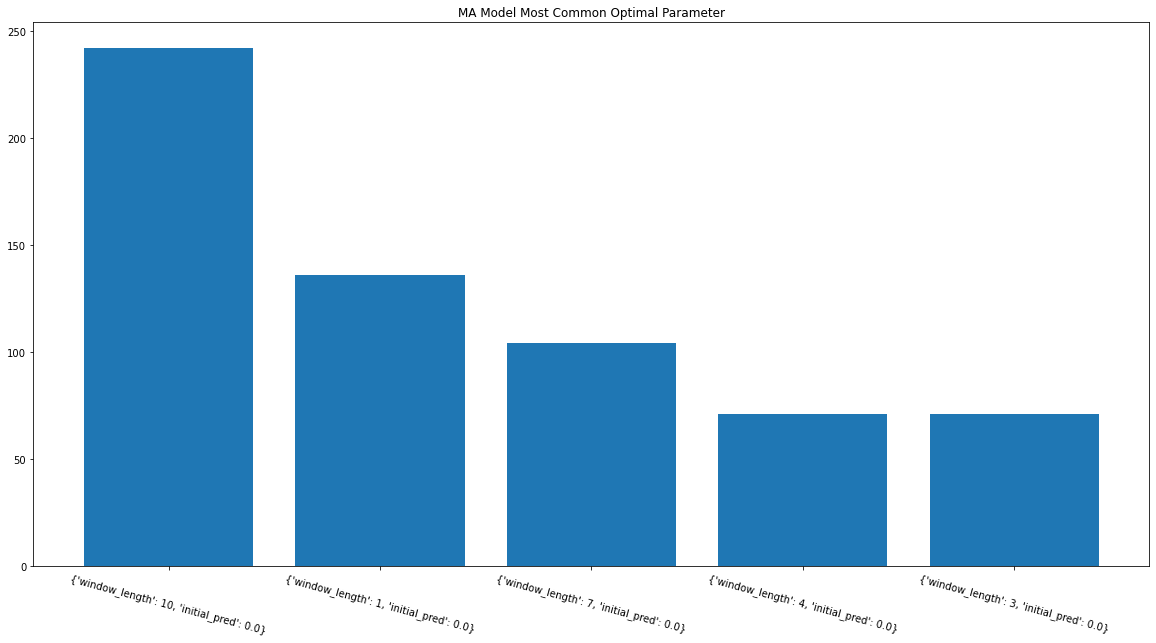

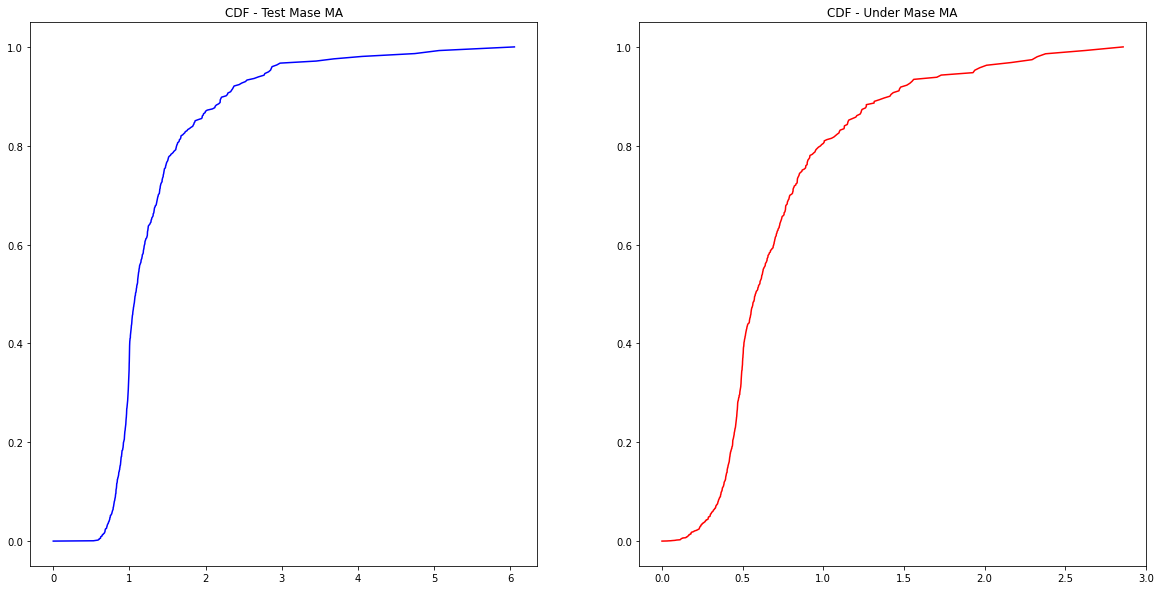

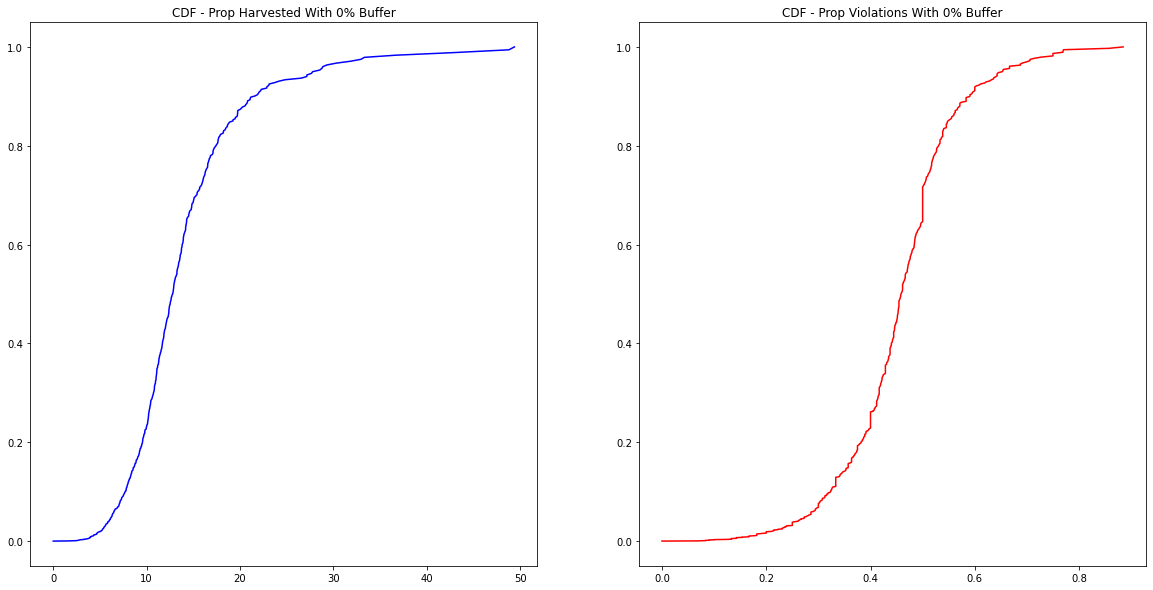

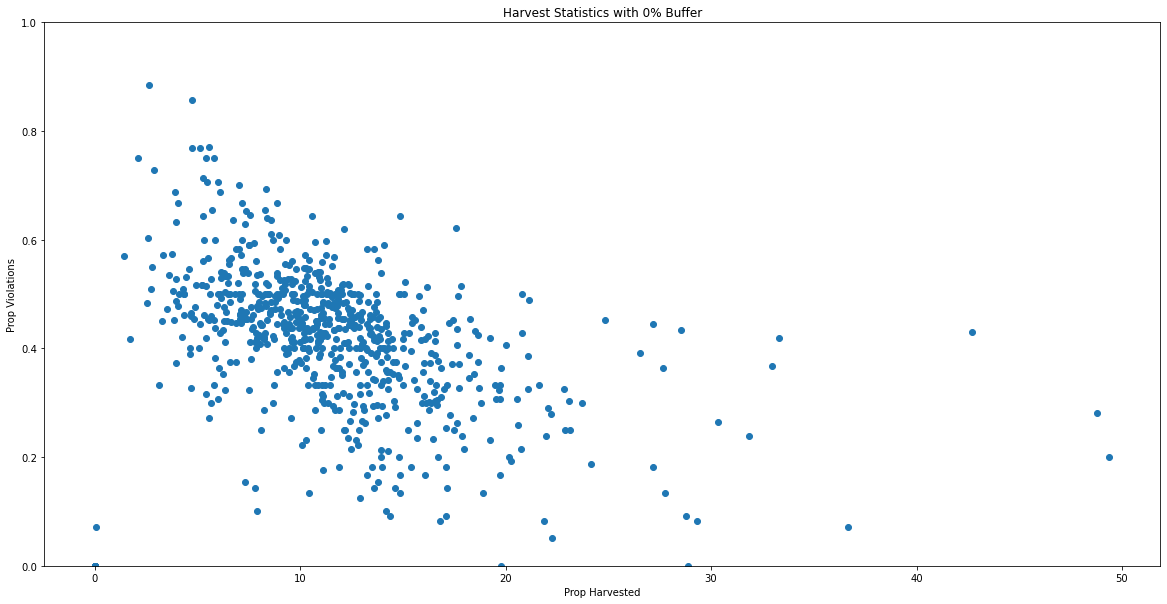

       prop_harvested  prop_violations
count      732.000000       732.000000
mean        11.474881         0.416554
std          5.607896         0.134505
min          0.000000         0.000000
25%          8.066977         0.352669
50%         11.020627         0.437500
75%         13.812846         0.500000
max         49.392985         0.884615


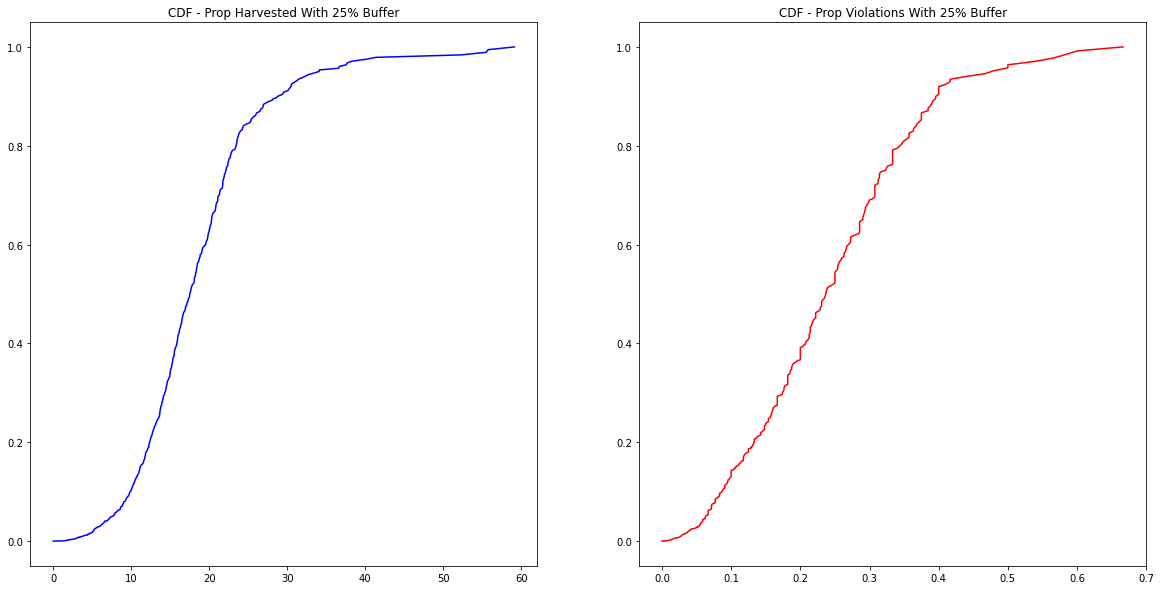

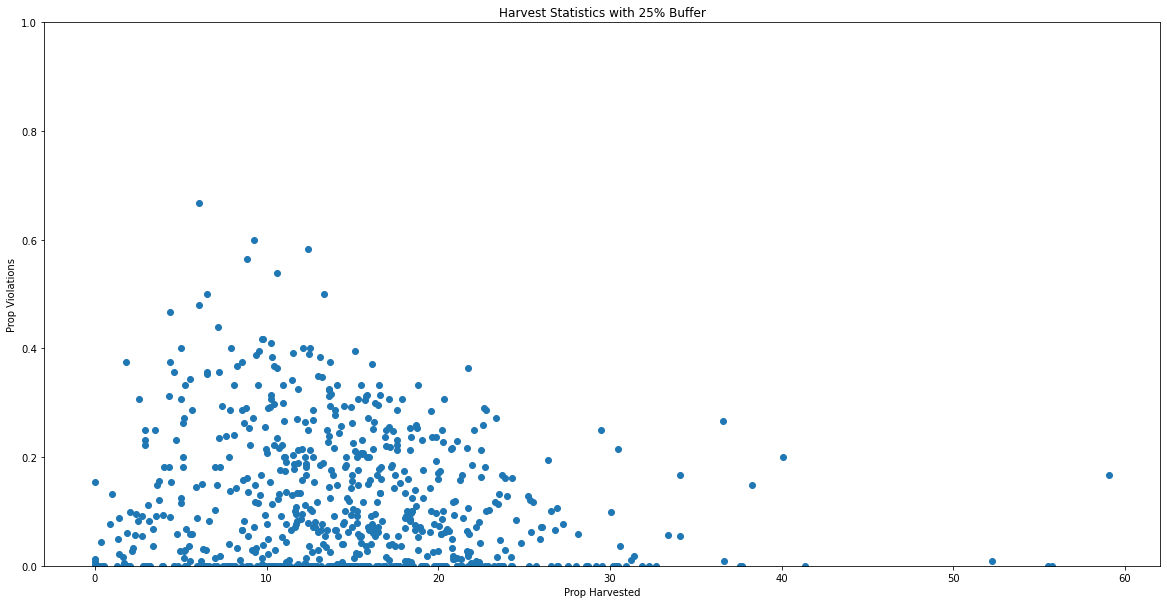

       prop_harvested  prop_violations
count      732.000000       732.000000
mean        14.391308         0.111595
std          7.976732         0.122919
min          0.000000         0.000000
25%          9.367577         0.000000
50%         14.123416         0.071429
75%         18.820791         0.187500
max         59.103647         0.666667


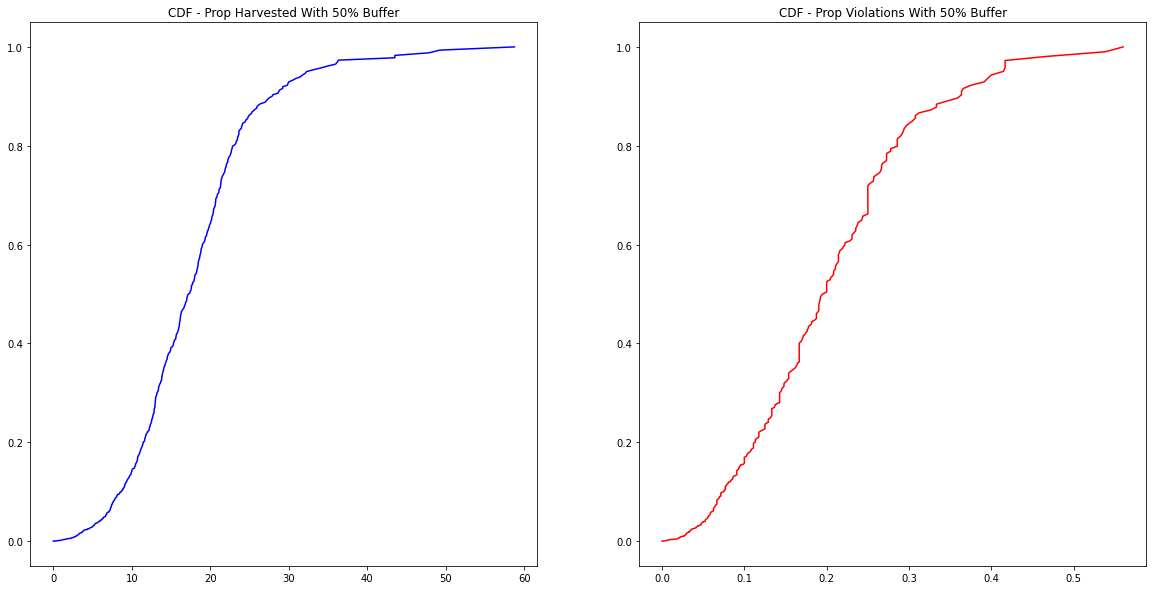

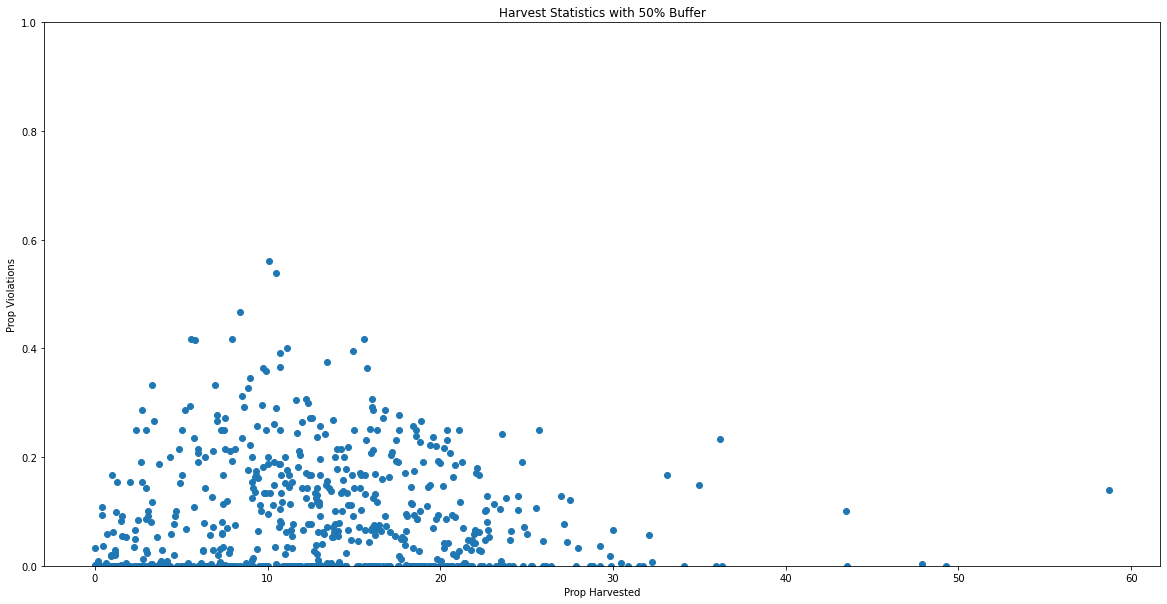

       prop_harvested  prop_violations
count      732.000000       732.000000
mean        12.390996         0.077746
std          8.391788         0.100598
min          0.000000         0.000000
25%          6.240400         0.000000
50%         12.347247         0.029715
75%         17.994514         0.136537
max         58.741944         0.560000


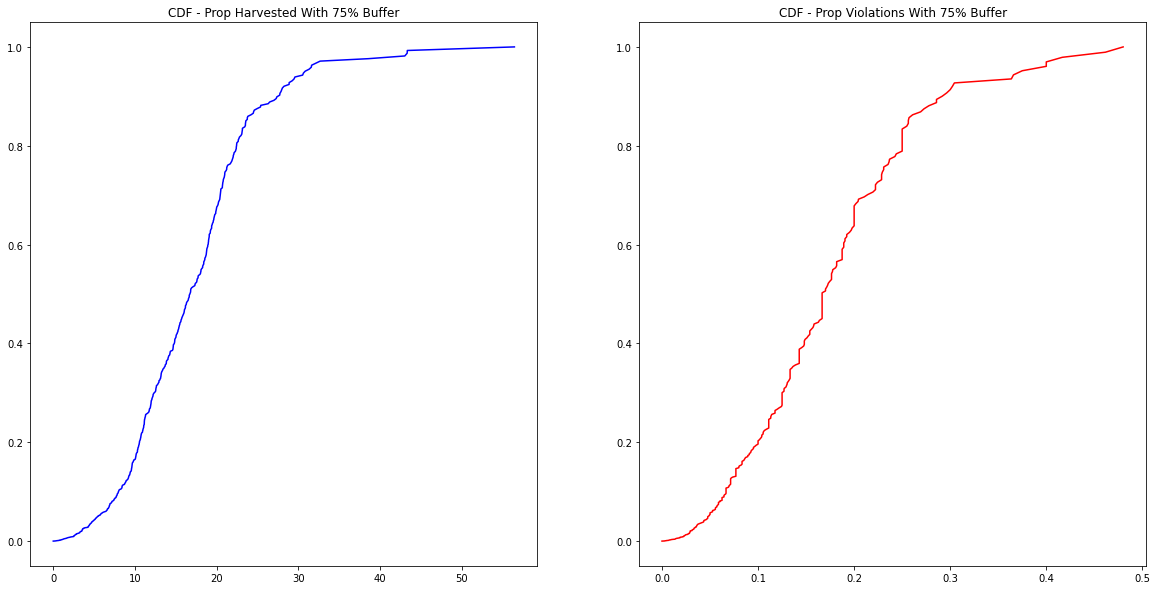

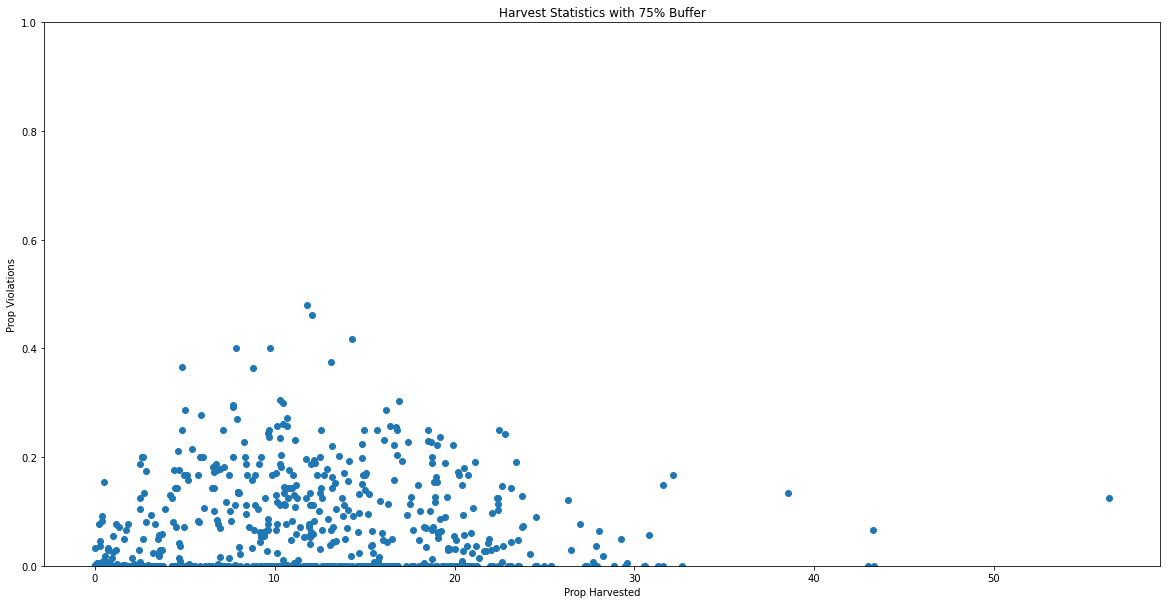

       prop_harvested  prop_violations
count      732.000000       732.000000
mean        10.669043         0.061139
std          8.430851         0.085246
min          0.000000         0.000000
25%          3.246320         0.000000
50%         10.297322         0.007302
75%         16.416266         0.111111
max         56.421301         0.480000


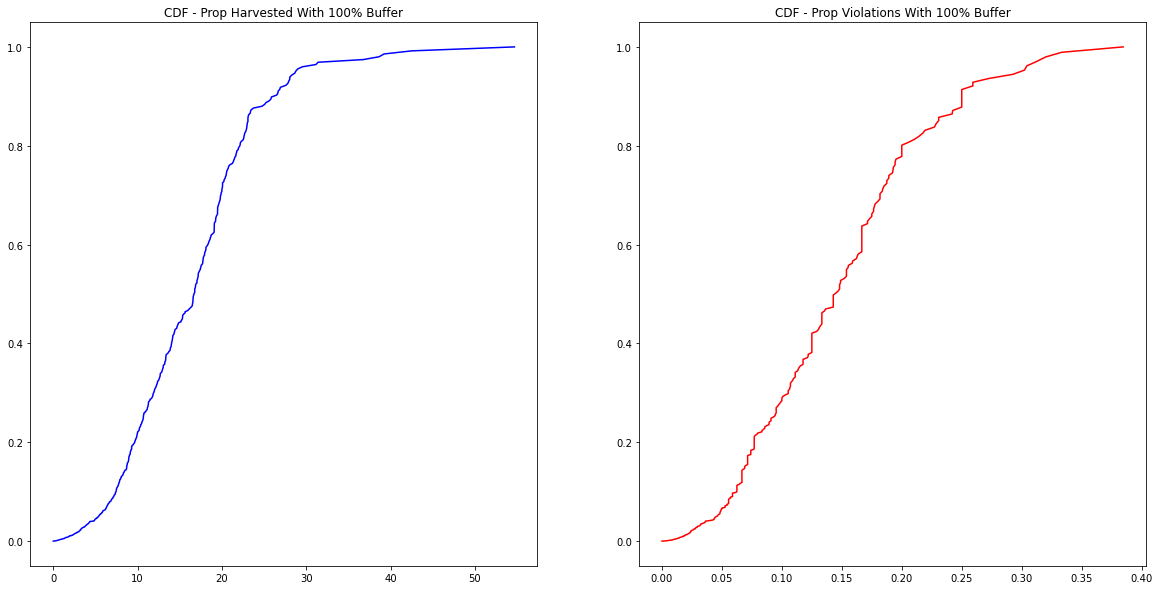

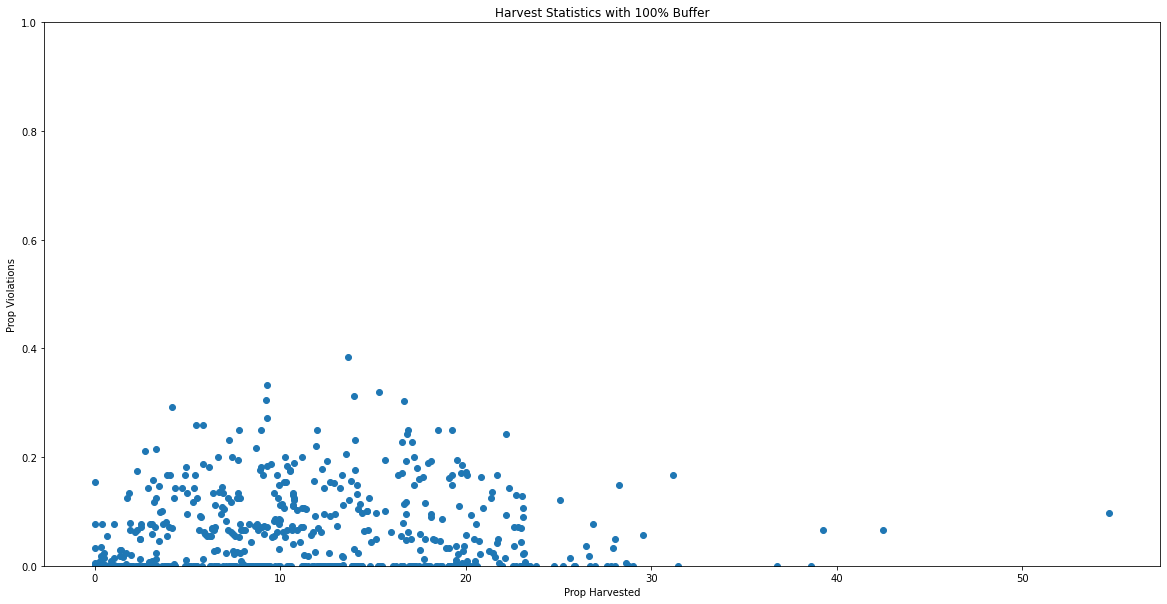

       prop_harvested  prop_violations
count      732.000000       732.000000
mean         9.324885         0.048159
std          8.277410         0.070269
min          0.000000         0.000000
25%          1.334354         0.000000
50%          8.362629         0.000000
75%         14.932209         0.076923
max         54.690402         0.384615


In [18]:
model_results_dfs['ma'] = get_model_results(max_mem_24_dir, 5, "ma")